# Data sets Carian and Jan

   Zeit  Butanal-200  Butyroin-200  Octandiol-200  Butanal-400  Butyroin-400  \
0    15   124.176166     15.794710       4.757150    28.994819     36.017133   
1    30    63.398964     25.996093      17.757670    11.689119     40.381425   
2    60    28.390328     23.062519      41.553822     4.193437     31.520589   
3   120    10.756477     12.852119      70.238170     2.898100     27.030057   
4   260     5.696028      6.645326      77.924077     0.670121     28.328524   

   Octandiol-400  Butanal-50p  Butyroin-50p  Octandiol-50p  Butanal-20  \
0      11.694228    71.550950     13.744815       5.412376   59.927461   
1      24.434737    27.924007     18.950706      21.574623   32.483592   
2      37.695268    13.727116     15.488127      47.128445   14.210708   
3      45.349974     7.647668      7.937782      66.535621   11.326425   
4      51.673427     4.383420      5.809739      70.456578    4.970639   

   Butyroin-20  Octandiol-20  
0    44.956117      0.087363  
1    52.2419

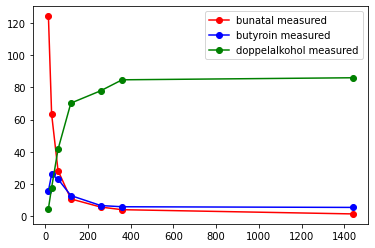

In [1]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"Jan_Carina_Daten.xlsx")

print(df.head())

butanal = df["Butanal-200"]
butyroin = df["Butyroin-200"]
octandiol = df["Octandiol-200"]

time = df["Zeit"]

print(time)

fix, ax = plt.subplots()

ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="-", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="-", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="-", marker="o")
ax.legend()
plt.plot()
plt.show()


[[124.1761658   63.39896373  28.39032815  10.75647668   5.69602763
    4.07253886   1.44732297]
 [ 15.79470995  25.99609258  23.06251879  12.85211903   6.64532612
    5.89389841   5.48512173]
 [  4.75715029  17.75767031  41.55382215  70.23816953  77.92407696
   84.71554862  85.98439938]]
[200, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 207
    # data points      = 21
    # variables        = 4
    chi-square         = 6871.46424
    reduced chi-square = 404.203779
    Akaike info crit   = 129.602811
    Bayesian info crit = 133.780901
[[Variables]]
    kA:  6.0860e-04 +/- 2.1245e-04 (34.91%) (init = 2)
    kP:  0.00121504 +/- 0.00356223 (293.18%) (init = 2)
    kC:  0.03565944 +/- 0.01828839 (51.29%) (init = 2)
    kD:  0.00368128 +/- 0.00521618 (141.69%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kC, kD) = 0.643
    C(kP, kD) = -0.634
    C(kP, kC) = -0.211
    C(kA, kP) = 0.185
    C(kA, kC) = -0.154
    C(kA, kD) =

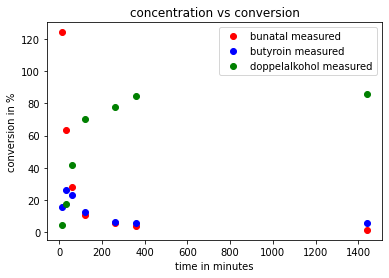

In [2]:
data_list = [butanal, butyroin, octandiol]

data = np.array(data_list)
print(data)
y0_array = [200, 0, 0]
print(y0_array)

def dbdt(kA, kB, kC, kD, A,P, C, t):
        dbdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
        return dbdt
def dcdt(kC, kD, P, C, t):
        dcdt = kC*P - kD*C
        return dcdt

def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.0030, 0.058, 0.042, 0.0000000002))

params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="", marker="o")

#ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
#ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
#ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")

ax.set_xlabel("time in minutes")
ax.set_ylabel("conversion in %")
ax.set_title("concentration vs conversion")



ax.legend()
plt.savefig("testfig-200-nomodel.svg", format="svg")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 21
    # variables        = 4
    chi-square         = 36634.5996
    reduced chi-square = 2154.97645
    Akaike info crit   = 164.748746
    Bayesian info crit = 168.926835
[[Variables]]
    kA:  0.00628588 +/- 0.01895140 (301.49%) (init = 2)
    kP:  1.76153146 +/- 7.40462835 (420.35%) (init = 2)
    kC:  0.71550981 +/- 3.08363043 (430.97%) (init = 2)
    kD:  2.9109e-08 +/- 0.00135599 (4658398.93%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kP, kC) = 0.975
    C(kC, kD) = 0.344
    C(kP, kD) = 0.227
    C(kA, kC) = -0.198
    C(kA, kP) = -0.156
    C(kA, kD) = -0.123
None


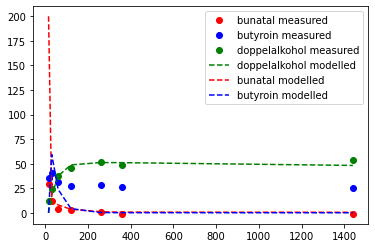

In [3]:
# reaction with 200 mM pDO

df = pd.read_excel(r"Jan_Carina_Daten.xlsx")

#print(df.head())

butanal = df["Butanal-400"]
butyroin = df["Butyroin-400"]
octandiol = df["Octandiol-400"]




data_list = [butanal, butyroin, octandiol]

data = np.array(data_list)
#print(data)
y0_array = [200, 0, 0]
#print(y0_array)

def dbdt(kA, kB, kC, kD, A,P, C, t):
        dbdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
        return dbdt
def dcdt(kC, kD, P, C, t):
        dcdt = kC*P - kD*C
        return dcdt

def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.01293752, 0.031, 0.017, 0.000113))


solution_200mM = sol

params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 21
    # variables        = 4
    chi-square         = 36634.5996
    reduced chi-square = 2154.97645
    Akaike info crit   = 164.748746
    Bayesian info crit = 168.926835
[[Variables]]
    kA:  0.00628588 +/- 0.01895140 (301.49%) (init = 2)
    kP:  1.76153146 +/- 7.40462835 (420.35%) (init = 2)
    kC:  0.71550981 +/- 3.08363043 (430.97%) (init = 2)
    kD:  2.9109e-08 +/- 0.00135599 (4658398.93%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kP, kC) = 0.975
    C(kC, kD) = 0.344
    C(kP, kD) = 0.227
    C(kA, kC) = -0.198
    C(kA, kP) = -0.156
    C(kA, kD) = -0.123
None


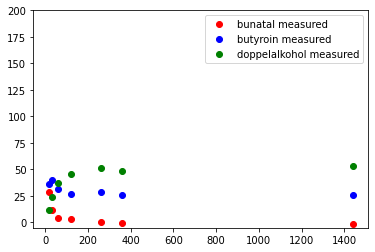

In [4]:
# Reaction with 50 percent PDO


df = pd.read_excel(r"Jan_Carina_Daten.xlsx")

#print(df.head())

butanal = df["Butanal-400"]
butyroin = df["Butyroin-400"]
octandiol = df["Octandiol-400"]




data_list = [butanal, butyroin, octandiol]

data = np.array(data_list)
#print(data)
y0_array = [200, 0, 0]
#print(y0_array)

def dbdt(kA, kB, kC, kD, A,P, C, t):
        dbdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
        return dbdt
def dcdt(kC, kD, P, C, t):
        dcdt = kC*P - kD*C
        return dcdt

def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.01293752, 0.031, 0.017, 0.000113))

params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="", marker="o")

#ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
#ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
#ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")
ax.set_ylim(-5, 200)

ax.legend()
plt.savefig("testfig-50.svg", format="svg")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 105
    # data points      = 21
    # variables        = 4
    chi-square         = 40987.3929
    reduced chi-square = 2411.02311
    Akaike info crit   = 167.106445
    Bayesian info crit = 171.284535
[[Variables]]
    kA:  2.58614393 +/- 244.889490 (9469.29%) (init = 2)
    kP:  1.68096888 +/- 41.3402108 (2459.31%) (init = 2)
    kC:  2.23206874 +/- 816.236771 (36568.62%) (init = 2)
    kD:  0.56378003 +/- 166.976294 (29617.28%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kC, kD) = 1.000
    C(kP, kC) = 0.999
    C(kP, kD) = 0.998
    C(kA, kC) = 0.338
    C(kA, kP) = 0.337
    C(kA, kD) = 0.336
None


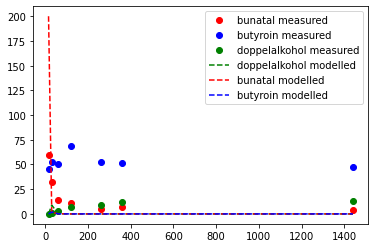

In [5]:
# Reaction with 20 mM PDO


df = pd.read_excel(r"Jan_Carina_Daten.xlsx")

#print(df.head())

butanal = df["Butanal-20"]
butyroin = df["Butyroin-20"]
octandiol = df["Octandiol-20"]




data_list = [butanal, butyroin, octandiol]

data = np.array(data_list)
#print(data)
y0_array = [200, 0, 0]
#print(y0_array)

def dbdt(kA, kB, kC, kD, A,P, C, t):
        dbdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
        return dbdt
def dcdt(kC, kD, P, C, t):
        dcdt = kC*P - kD*C
        return dcdt

def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(1.48, 1.55, 2.12, 0.58))

params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")

[[2.00000000e+02 0.00000000e+00 0.00000000e+00]
 [1.26076324e+01 5.93691574e+01 1.79482404e+01]
 [8.11859258e+00 2.38303474e+01 3.76644556e+01]
 [3.72071652e+00 4.36090733e+00 4.88537205e+01]
 [1.15355530e+00 3.66479472e-01 5.12320825e+01]
 [8.17557095e-01 2.22156451e-01 5.11195495e+01]
 [6.36411646e-01 1.68479724e-01 4.83009158e+01]]
butanal [200.          12.60763241   8.11859258   3.72071652   1.1535553
   0.8175571    0.63641165]
butyroin [ 0.         17.94824042 37.66445557 48.85372045 51.23208252 51.11954951
 48.30091577]
octandiol [ 0.         17.94824042 37.66445557 48.85372045 51.23208252 51.11954951
 48.30091577]


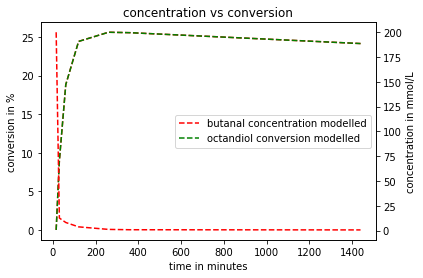

In [6]:
print(solution_200mM)

print("butanal", solution_200mM[:,0])
print("butyroin", solution_200mM[:,2])
print("octandiol", solution_200mM[:,2])


conversion = []

for i in solution_200mM[:,2]:
    conv = (i/200)*100
    conversion.append(conv)


fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(time, conversion, label="butanal concentration modelled", color="red", linestyle="--", marker="")
ax.plot(time, conversion, label="octandiol conversion modelled", color="green", linestyle="--", marker="")

ax2.plot(time, solution_200mM[:,0], label="bunatal measured", color="red", linestyle="--", marker="")
ax.legend(loc=5)
#ax2.legend()

ax.set_xlabel("time in minutes")
ax.set_ylabel("conversion in %")
ax.set_title("concentration vs conversion")

ax2.set_ylabel("concentration in mmol/L")

plt.savefig("conversion.svg", format="svg")
